#AUTOCODER


Open this notebook in [Google Colab](https://colab.research.google.com). You can do this by using the Chrome plugin [Open in Colab](https://chrome.google.com/webstore/detail/open-in-colab/iogfkhleblhcpcekbiedikdehleodpjo),<br>
or by downloading it from github and uploading it into colab.<br><br>
Make sure to set the runtime type to GPU (Runtime->Change Runtime Type) or training will take<br>an enternity.<br><br>
You can run each code section by pressing the play button which shows up when you hover over the<br> two brackets with/without a number on the top left of the codebox.
<br>

#1. UPLOAD A SOUNDFILE 
Click on the folder icon on the left to expand the file browser and drag and drop a sound-file there.<br>Then edit the filename below to match the uploaded file. Make sure that the file finishes uploading<br> before continuing.

In [ ]:
filename = "impulses-2.wav"

Alternatively, you can download a file from the internet into the notebook and set the filename.

In [ ]:
filename = "Fanfare60.wav"
!wget https://www2.cs.uic.edu/~i101/SoundFiles/Fanfare60.wav
#!wget https://archive.org/download/WagnerTheRideOfTheValkyries/WagnerTheRideOfTheValkyrieswww.keepvid.com.mp3

--2022-03-04 18:04:05--  https://www2.cs.uic.edu/~i101/SoundFiles/Fanfare60.wav
Resolving www2.cs.uic.edu (www2.cs.uic.edu)... 131.193.32.16
Connecting to www2.cs.uic.edu (www2.cs.uic.edu)|131.193.32.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2646044 (2.5M) [audio/x-wav]
Saving to: ‘Fanfare60.wav.1’

Fanfare60.wav.1     100%[===================>]   2.52M  1.33MB/s    in 1.9s    

2022-03-04 18:04:08 (1.33 MB/s) - ‘Fanfare60.wav.1’ saved [2646044/2646044]



#2. SELECT ONE OF THE FOLLOWING TO SET THE TRAINING PARAMETERS
Some of these presets may not produce usable models with specific datasets
so some patience <br>and experimentation may be needed. More training is not always better and some data-sets may<br> need different (lower) values for regression patience to avoid artifacting.<br>

In [ ]:
# LOW QUALITY - TRAINING TIME ROUGHLY .8x DURATION – GOOD ENOUGH FOR EXPLORATION
batch_size = 1024
regression_patience = 200
learning_rate = .0001
min_delta = .00001
quality = "low"

In [ ]:
# MEDIUM QUALITY – TRAINING TIME ROUGHLY 3x DURATION – GOOD ENOUGH FOR MOST THINGS
batch_size = 512
regression_patience = 500
learning_rate = .0001
min_delta = .00001
quality = "medium"

In [ ]:
# HIGH QUALITY – TRAINING TIME ROUGHLY 5x DURATION
batch_size = 256
regression_patience = 1000 
learning_rate = .0001
min_delta = .00001
quality = "high"

In [ ]:
# EXTREME QUALITY – TRAINING TAKES A VERY LONG TIME
batch_size = 256
regression_patience = 10000000
learning_rate = .0001
min_delta = 0
quality = "extreme"

#3. RUN THE CODE
Depending on the training settings selected above, this can take anywhere from
.5x to 5x or more<br> of the duration of the input file so be patient.

In [ ]:

!pip install python_speech_features
import librosa
import numpy as np
import scipy
from scipy.signal import hann
from python_speech_features.base import get_filterbanks
import tensorflow as tf
import tensorflow.keras.backend as K
import math
import time

# ANALYSIS SETTINGS
fftsize = 16384
windowskip = 1024

# MODEL STRUCTURE
input_dim = 512
intermediate_dim = 1000
encoded_dim = 8
output_fft_size = 8192

def create_mel_filter(fft_size, n_freq_components = 64, start_freq = 300, end_freq = 8000, samplerate = 44100):
    filterbanks = get_filterbanks(nfilt=n_freq_components,
                                           nfft=fft_size, samplerate=samplerate,
                                           lowfreq=start_freq, highfreq=end_freq)
    mel_inversion_filter = np.ascontiguousarray((filterbanks.T[0:(int(fft_size/2))]).T)
    mel_filter = np.ascontiguousarray(np.divide(mel_inversion_filter.T, mel_inversion_filter.sum(axis=1)))

    return mel_filter, mel_inversion_filter


def initialize(size, melsize):
    window = np.zeros((1, size))
    window = np.ascontiguousarray(window)
    window[0,] = hann(size)
    mel_filter, mel_inversion_filter = create_mel_filter(size, melsize, 0, 22050, 44100)
    np.nan_to_num(mel_filter, False, nan = 0.0)
    np.nan_to_num(mel_inversion_filter, False, nan = 0.0)
    return(mel_filter, mel_inversion_filter, window)


def convertToBin(data):
    return(np.sqrt(np.add(np.multiply(data.real, data.real), np.multiply(data.imag, data.imag))))


def spectrogram_to_mel(spectrogram, filter):
    mel_spec = np.transpose(filter).dot(np.transpose(spectrogram))
    return mel_spec


def get_aminmax(X):
    return(np.amin(X), np.amax(X))


def scale_array_by_amax(X):
    return((X - np.amin(X)) / (np.amax(X) - np.amin(X)))


def analyze(data, window, mel_filter):
    data = np.multiply(data, window)
    fftdata = scipy.fft.rfft(data)
    ampslize = convertToBin(fftdata)
    ampslize = np.ascontiguousarray(ampslize)
    #phase = np.angle(fftdata)
    melslize = spectrogram_to_mel(ampslize[0,0:int(data.shape[1]/2)], mel_filter)
    return(melslize, ampslize[0,0:int(data.shape[1]/2)])


def analyze_data(data, filename, fftsize, windowskip, melsize, window, mel_filter):

    n_slizes = round(len(data)/windowskip)
    output = np.zeros((int((n_slizes - 16))+1, melsize))
    output = np.ascontiguousarray(output)
    fft_output = np.zeros((int((n_slizes - 16))+1, int(fftsize / 2)))
    fft_output = np.ascontiguousarray(fft_output)

    in_slize = np.zeros((1, fftsize))
    in_slize = np.ascontiguousarray(in_slize)
    for i in range(0, (n_slizes - 16)):
        in_slize[0] = data[i * windowskip:((i*windowskip) + fftsize)]
        output[i,:], fft_output[i,:] = analyze(in_slize, window, mel_filter)

    output = np.nan_to_num(output, 0.)
    minin, maxin = get_aminmax(output)
    output = scale_array_by_amax(output)

    np.save(filename + ".npy", output)
    #np.save(filename + ".fft.npy", fft_output)
    return(minin, maxin, output)


def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    epsilon = 1e-06
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def init_autoencoder_shallow(input_dim, intermediate_dim, encoded_dim, learning_rate):

    input_shape = (input_dim, )
    latent_dim = encoded_dim

    print("input_shape: ", input_shape)

    # VAE model = encoder + decoder
    # build encoder model
    inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
    x = tf.keras.layers.Dense(intermediate_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5), kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(inputs)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
    x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = tf.keras.layers.Dense(input_dim, activation='sigmoid')(x)

    # instantiate decoder model
    _,mel_inversion_filter = create_mel_filter(output_fft_size, input_dim, 0, 22050, 44100)
    mel = K.expand_dims(tf.constant(mel_inversion_filter), 0)
    transformed_outputs = tf.keras.layers.Dot(axes=(1,1)) ([outputs, mel])
    decoder = tf.keras.Model(latent_inputs, transformed_outputs, name='decoder')
    training_decoder = tf.keras.Model(latent_inputs, outputs, name='training_decoder')
    decoder.summary()
    training_decoder.summary()
    # instantiate VAE model
    training_outputs = training_decoder(encoder(inputs)[2])
    outputs = decoder(encoder(inputs)[2])


    vae = tf.keras.Model(inputs, [training_outputs,outputs], name='vae_mlp')

    reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, training_outputs)

    reconstruction_loss *= input_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    opt = tf.keras.optimizers.Adam(lr=learning_rate)

    vae.compile(optimizer=opt)
    return(vae, encoder, decoder, training_decoder)


def get_minmax(encoder, input):
    z_encoded = encoder.predict(input)
    z_encoded = np.asarray(z_encoded[0], dtype = np.float32)

    min = z_encoded.min(axis = 0)
    max = z_encoded.max(axis = 0)
    scale_mult = np.subtract(max, min)
    scale_subtract = min
    return(scale_mult, scale_subtract)

history = 0

def train(filename, vae, encoder, decoder, training_decoder, input, min_delta, regression_patience = 1, batch_size = 4096, deep = 0):
    global history
    tf.executing_eagerly()
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=min_delta, patience = regression_patience)
    history = vae.fit(input,
            batch_size = batch_size,
            epochs=50000, verbose = 0, callbacks=[es])

    vae.save_weights(filename + ".h5")
    scale_mult, scale_subtract = get_minmax(encoder, input)

    converter_enc = tf.lite.TFLiteConverter.from_keras_model(encoder)
    converter_dec = tf.lite.TFLiteConverter.from_keras_model(decoder)
    converter_training_dec = tf.lite.TFLiteConverter.from_keras_model(training_decoder)
    tflite_model_enc = converter_enc.convert()
    tflite_model_dec = converter_dec.convert()
    tflite_model_training_dec = converter_training_dec.convert()

    # Save the models
    with open(filename + '.enc', 'wb') as f:
      f.write(tflite_model_enc)
    with open(filename + '.fft.dec', 'wb') as f:
      f.write(tflite_model_dec)
    with open(filename + '.dec', 'wb') as f:
      f.write(tflite_model_training_dec)

    return(vae, encoder, decoder, training_decoder, scale_mult, scale_subtract)


def write_mm(filename, minin, maxin, scale_mult, scale_subtract, input_dim, intermediate_dim, encoded_dim, deep):
    output_ = np.zeros([3, 8])
    output_[0] = scale_mult
    output_[1] = scale_subtract
    output_[2][0] = minin
    output_[2][1] = maxin
    output_[2][2] = input_dim
    output_[2][3] = intermediate_dim
    output_[2][4] = encoded_dim
    output_[2][5] = deep
    np.savetxt(filename + ".mm", output_, delimiter = ", ", fmt="%1.6f")
  
imported_data,_ = librosa.load(filename, sr = 44100, mono = True)
print("  ...ANALYZING")
print("")
print("  ####################################")
print("  #   number of samples:  ", len(imported_data))
print("  ####################################")
print("")

mel_filter, mel_inversion_filter, window = initialize(fftsize, input_dim)
minin, maxin, input_data = analyze_data(imported_data, filename, fftsize, windowskip, input_dim, window, mel_filter)
# HAVE THIS GUY RETURN THE INPUT_DATA AND THE FFT DATA
np.savetxt(filename + ".minmax", np.asarray([[minin, maxin]]), delimiter = ", ")
print("  ...INITIALIZING AUTOENCODER")
vae, encoder, decoder, training_decoder = init_autoencoder_shallow(input_dim, intermediate_dim, encoded_dim, learning_rate)
print("  ...TRAINING")
at = time.time()
vae, encoder, decoder, training_decoder, scale_mult, scale_subtract = train(filename, vae, encoder, decoder, training_decoder, input_data, min_delta, regression_patience, batch_size, 0)
write_mm(filename, minin, maxin, scale_mult, scale_subtract, input_dim, intermediate_dim, encoded_dim, 0)
print("   ... time spent training:", time.time()-at)

fileout = "/content/" + filename + "." + quality + ".zip"
print(fileout)
file1 = "/content/" + filename
file2 = "/content/" + filename + ".fft.dec"
file3 = "/content/" + filename + ".mm"
!zip -r $fileout $file1 $file2 $file3

print("")
print(quality, "quality")

from google.colab import files
files.download(fileout)


  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=597c2831e844d2965df62fcad34a932f7faf7bd1dd38a5e971084af0e2799c8e
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

<-- You can download the model as a zip file from the file browser on the left.

#4. Visualize the Model and Check Quality (Optional)
It is a little hard to interpret the output of the following graphs but they might prove helpful in<br> analyzing when a model is under or overfitting the data.

In [ ]:
z_encoded = encoder.predict(input_data)
output_data = training_decoder.predict(z_encoded[0])
difference = np.abs(np.subtract(input_data, output_data))

print("")
print("    ... maximum reconstruction error:", np.amax(difference))
print("    ... average reconstruction error:", np.average(difference))



    ... maximum reconstruction error: 0.058429060378061115
    ... average reconstruction error: 0.0007665073109138286


... input data ...


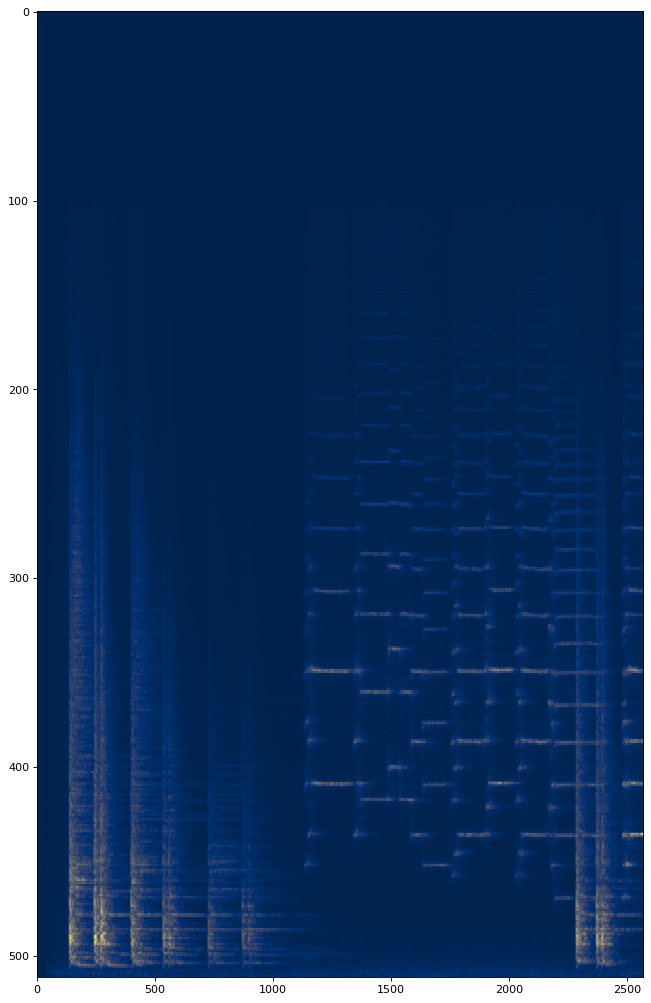


... output data ...


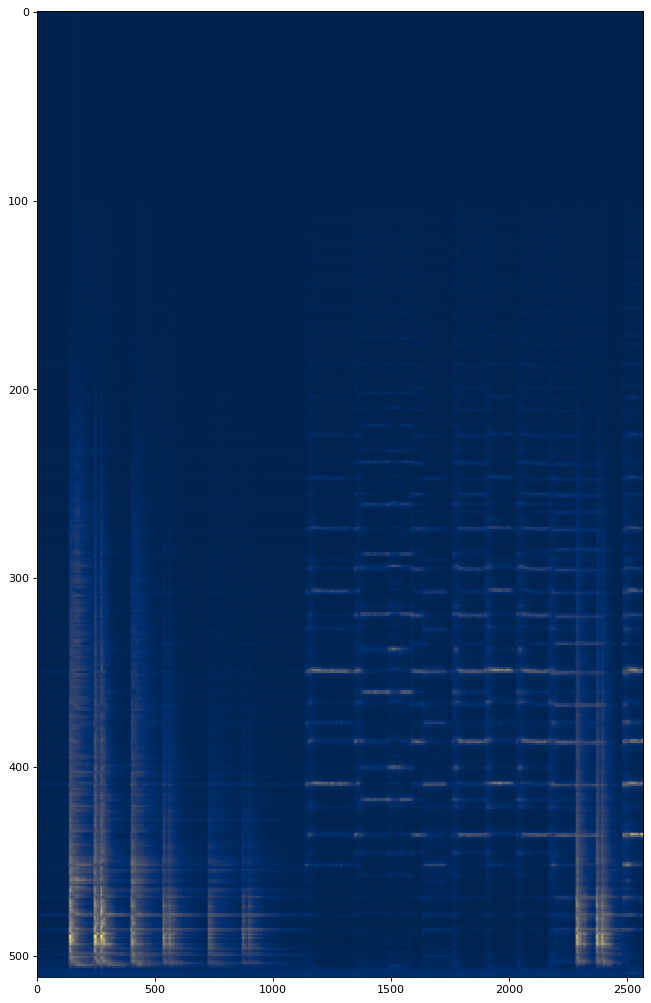


... difference between input and output ...


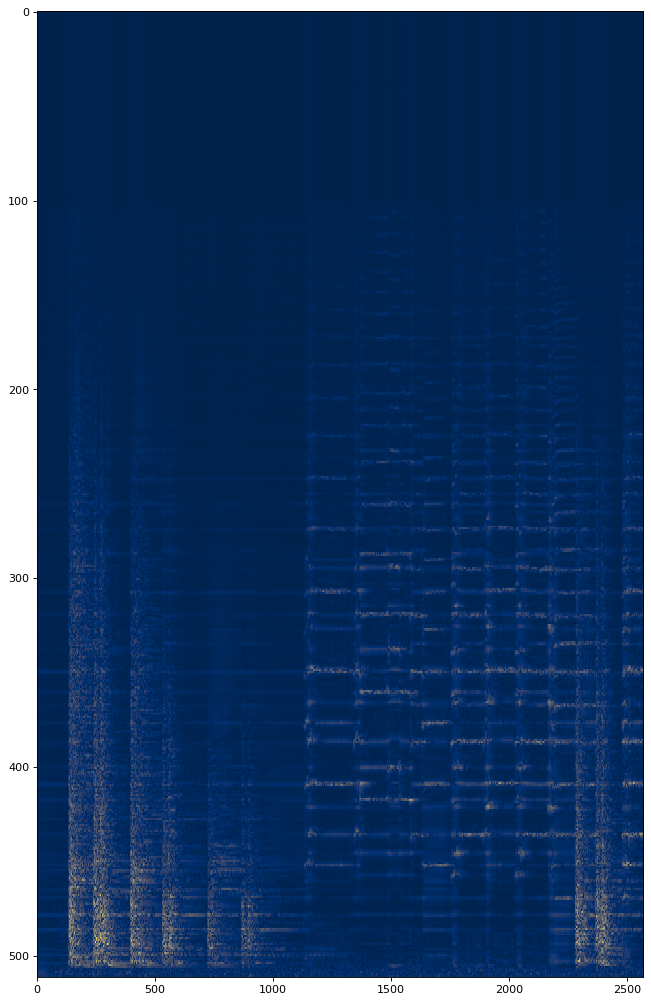


... joint error (normalized per bin)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


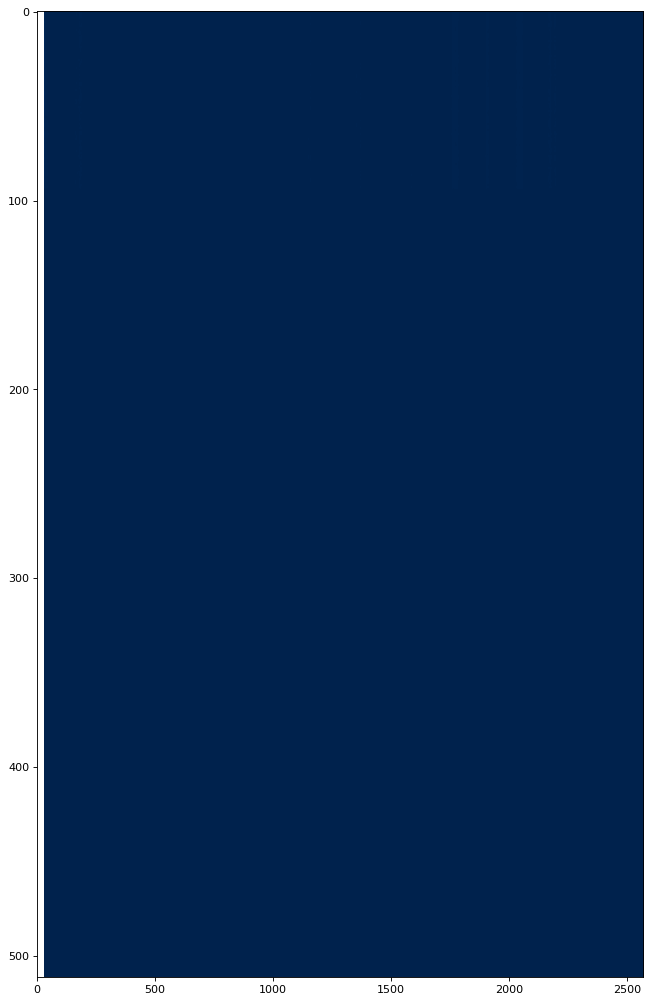


... negative error (normalized per bin) ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


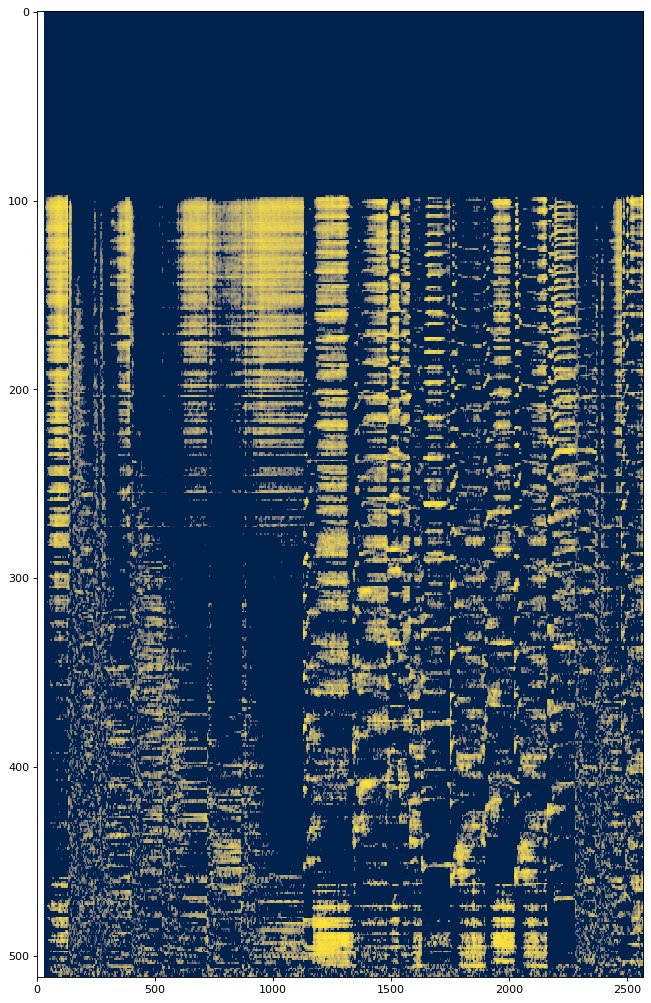


... positive error (normalized per bin)...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


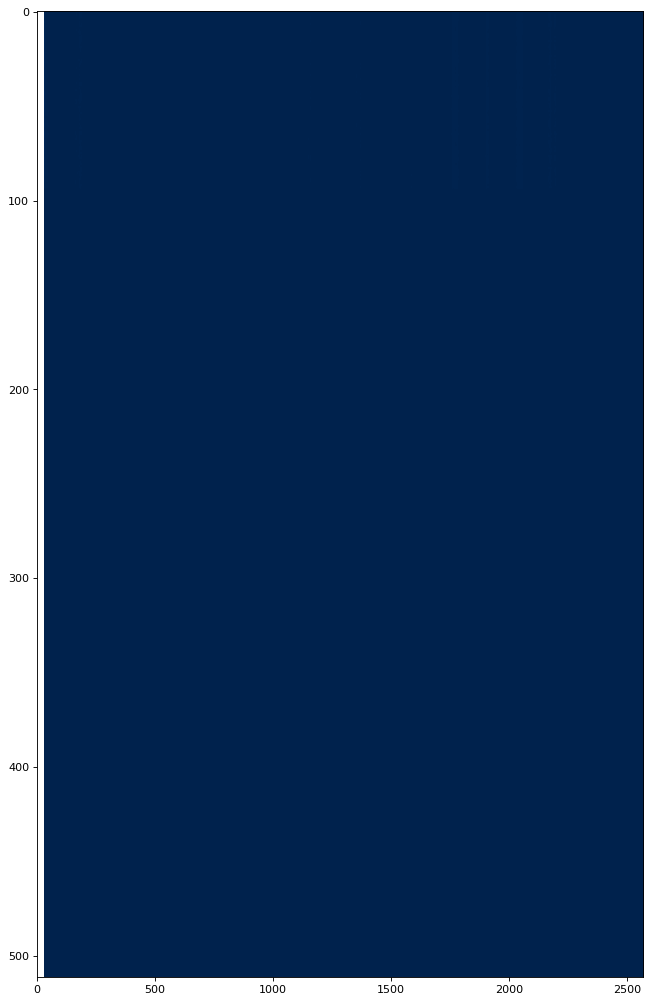

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print("... input data ...")
figure(figsize=(16, 16), dpi=80)
plt.imshow(np.power(np.flipud(input_data.T), .5), cmap='cividis', interpolation='nearest', aspect = 8.)
plt.show()

print("")

print("... output data ...")
z_encoded = encoder.predict(input_data)
output_data = training_decoder.predict(z_encoded[0])
figure(figsize=(16, 16), dpi=80)
plt.imshow(np.power(np.flipud(output_data.T), .5), cmap='cividis', interpolation='nearest', aspect = 8.)
plt.show()

print("")

difference = np.abs(np.subtract(input_data, output_data))
print("... difference between input and output ...")

figure(figsize=(16, 16), dpi=80)
plt.imshow(np.power(np.flipud(difference.T), .5), cmap='cividis', interpolation='nearest', aspect = 8.)
plt.show()

print("")
print("... joint error (normalized per bin)")
figure(figsize=(16, 16), dpi=80)
plt.imshow(np.divide(np.power(np.flipud(difference.T), .5), np.power(np.flipud(input_data.T), .5)), cmap='cividis', interpolation='nearest', aspect = 8.)
plt.show()

print("")
print("... negative error (normalized per bin) ...")
difference = np.subtract(input_data, output_data)
difference = np.clip(difference, 0, np.amax(difference))
figure(figsize=(16, 16), dpi=80)
plt.imshow(np.divide(np.power(np.flipud(difference.T), .5), np.power(np.flipud(input_data.T), .5)), cmap='cividis', interpolation='nearest', aspect = 8.)
plt.show()


print("")
print("... positive error (normalized per bin)...")
difference = np.subtract(output_data, input_data)
difference = np.clip(difference, 0, np.amax(difference))
figure(figsize=(16, 16), dpi=80)
plt.imshow(np.divide(np.power(np.flipud(difference.T), .5), np.power(np.flipud(input_data.T), .5)), cmap='cividis', interpolation='nearest', aspect = 8.)
plt.show()
